In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import scipy

(가정) 유기첨가제 brightner(광택제)는 실제 장비의 구동 시간과 선형 관계에 있을것이다.
- 데이터는 간헐적 데이터가 아닌 연속된 데이터로 가정
- 데이터는 1일 1회 첨가제를 주입

Min : 1.6
Max : 2.9
Mean : 2.1901960784313728


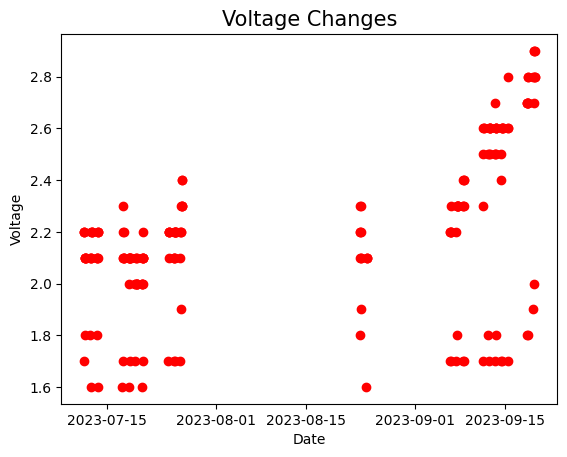

<Axes: ylabel='Density'>

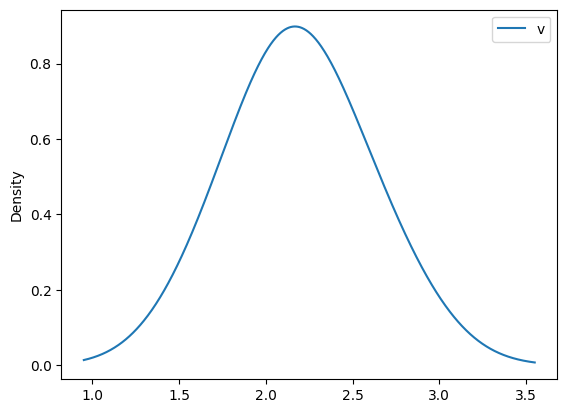

In [114]:
# read raw data
csv_raw = pd.read_csv("./data/data.csv", skiprows=1, parse_dates=['datetime'], dayfirst=False)

# show voltage
data_v = csv_raw[['datetime', 'v']].dropna().sort_values("datetime")
data_v = data_v.set_index('datetime').sort_index()

print(f"Min : {data_v['v'].min()}")
print(f"Max : {data_v['v'].max()}")
print(f"Mean : {data_v['v'].mean()}")

# draw
plt.clf()
plt.plot(data_v, 'ro')
plt.xlabel('Date')
plt.ylabel('Voltage')
plt.title('Voltage Changes', fontsize=15)
plt.show()

data_v.plot.kde(bw_method=1)


In [ ]:
# select only add_amont_brightener column without NaN
brightner_data = csv_raw[['datetime', 'add_amont_brightener']].dropna().sort_values("datetime")
group = brightner_data.groupby(pd.Grouper(key='datetime', freq='D', sort=True)).count()
print(group)



#worktime = pd.DataFrame(columns=['datetime', 'Age'])

#datelist = brightner_data.groupby(brightner_data['datetime'].dt.day)
#datelist = brightner_data.groupby(by=brightner_data.dt.day).count()
#print(datelist)

In [31]:
ts = csv_raw['2023-07-11':'2023-07-12']
print(ts)

                           copper_sulfate_content  sulfuric_acid_content  \
datetime                                                                   
2023-07-11 08:55:00+00:00                     NaN                    NaN   
2023-07-11 09:20:00+00:00                     NaN                    NaN   
2023-07-11 09:40:00+00:00                     NaN                    NaN   
2023-07-11 10:00:00+00:00                     NaN                    NaN   
2023-07-11 11:00:00+00:00                     NaN                    NaN   
2023-07-11 12:35:00+00:00                     NaN                    NaN   
2023-07-11 13:00:00+00:00                     NaN                    NaN   
2023-07-11 13:30:00+00:00                     NaN                    NaN   
2023-07-11 14:00:00+00:00                     NaN                    NaN   
2023-07-11 14:30:00+00:00                     NaN                    NaN   
2023-07-11 15:00:00+00:00                     NaN                    NaN   
2023-07-11 1

In [4]:
from dateutil import parser
date = parser.parse("2023-07-11T08:55:00Z")
print(date)

2023-07-11 08:55:00+00:00
